In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import GaussianNoise
import os
import tensorflow.keras.backend as K
from matplotlib.pyplot import imshow
from sklearn.utils import shuffle
np.seterr(divide='ignore', invalid='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D,GRU, LSTM, UpSampling1D,GlobalMaxPooling1D, SeparableConv1D,BatchNormalization,UpSampling1D, Conv2D
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D, Dropout, LeakyReLU, Add, Activation, Concatenate, Permute, Attention, Activation, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Layer, SimpleRNN, Embedding, GRU, Bidirectional, UpSampling2D,Reshape,Convolution2D, InputLayer
from tensorflow.keras import layers
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Conv2DTranspose
import math
import tensorflow.keras.layers
import tensorflow.keras as keras
import warnings
# import tensorflow_gan as tfgan
# from tqdm import tqdm
# from diffaug import DiffAugment

## Data processing

In [14]:
train_x = np.zeros((200,256,256,3))
t = 0
for i in range(100):
    img = cv2.imread("Aug_output/input16_"+str(1+i)+".tif")
    train_x[t] = img
    t += 1
#     img = cv2.imread("Aug_output/input6_"+str(1+i)+".tif")
#     train_x[t] = img
#     t += 1
    img = cv2.imread("Aug_output/input3_"+str(1+i)+".tif")
    train_x[t] = img
    t += 1      

In [16]:
np.save("train_x",train_x)

In [18]:
img = cv2.imread("Aug_output/input16_"+str(1)+".tif")

In [22]:
train_y = np.zeros((200,256,256,3))
t = 0
for i in range(100):
    img = cv2.imread("Aug_output/label16_"+str(1+i)+".tif")
    train_y[t] = img
    t += 1
#     img = cv2.imread("Aug_output/input6_"+str(1+i)+".tif")
#     train_x[t] = img
#     t += 1
    img = cv2.imread("Aug_output/label3_"+str(1+i)+".tif")
    train_y[t] = img
    t += 1      

In [24]:
np.save("train_y",train_y)

In [30]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")

In [31]:
train_x = train_x[:,:,:,0]
train_y = train_y[:,:,:,0]

In [32]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2],1)
train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], train_y.shape[2],1)

In [33]:
train_y = train_y/255

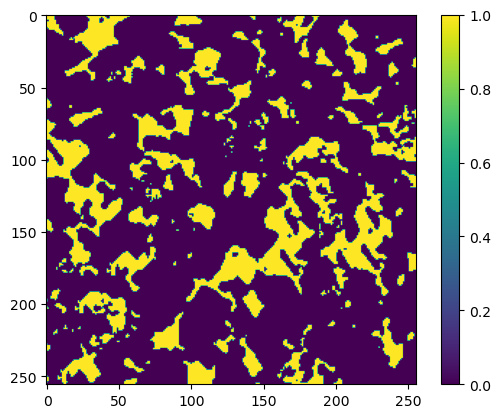

In [35]:
## set to be 0/1
plt.imshow(train_y[15,:,:,0])
plt.colorbar()

In [36]:
## Split data
train_x,train_y=shuffle(train_x,train_y)
num=int(train_x.shape[0]*0.8)
val_x=train_x[num:]
train_x=train_x[0:num]
val_y=train_y[num:]
train_y=train_y[0:num]

In [135]:
## Define U-net model
# n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[0]-1
input_layer = Input(shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3]))
# Entry block
x = Conv2D(8, 3, strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Activation("relu")(x)
previous_block_activation = x  

for filters in [8, 16, 32]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
    x = add([x, residual])  
    previous_block_activation = x  


for filters in [32, 16, 8, 8]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = add([x, residual])  
    previous_block_activation = x 
outputs = Conv2D(1,3, padding = "same", activation="linear")(x)
model = Model(input_layer,outputs)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 128, 128, 8)  80          input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 128, 128, 8)  32          conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 128, 128, 8)  0           batch_normalization_60[0][0]     
____________________________________________________________________________________________

In [76]:
## self define a loss function
def soft_dice_loss(y_true, y_pred): 
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(np.square(y_pred) + np.square(y_true),axes)
    
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch
    


In [110]:
## try pixel-wise cross-entropy
"""
    Pixel-wise cross-entropy loss for dense classification of an image.
       
    The loss of a misclassified `1` needs to be weighted
    `WEIGHT` times more than a misclassified `0` (only 2 classes).
   
    Inputs
    ----------------
    y_true: Correct labels of 3D shape (batch_size, img_rows*img_cols, num_classes).
   
    y_pred: Predicted softmax probabilities of each class for each img_rows*img_cols pixel.
            Same 3D shape as y_true.
    """
def pixelwise_crossentropy(y_true, y_pred):
    y_true = tf.reshape(y_true, [10,256*256])
    y_pred = tf.reshape(y_pred, [10,256*256])
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return K.sum(loss)
    
   
    

## Try different loss function

#### 1. Soft dice loss

In [77]:
## Try soft dice loss
model.compile("adam",soft_dice_loss)
history1=model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=40, batch_size=10, shuffle=True)

Train on 160 samples, validate on 40 samples
Epoch 1/40
160/160 [==============================] - 39s 244ms/sample - loss: 0.8896 - val_loss: 1.0292
Epoch 2/40
160/160 [==============================] - 37s 229ms/sample - loss: 0.7172 - val_loss: 1.0314
Epoch 3/40
160/160 [==============================] - 34s 213ms/sample - loss: 0.6050 - val_loss: 1.0446
Epoch 4/40
160/160 [==============================] - 38s 240ms/sample - loss: 0.5986 - val_loss: 1.0896
Epoch 5/40
160/160 [==============================] - 37s 228ms/sample - loss: 0.4940 - val_loss: 1.0197
Epoch 6/40
160/160 [==============================] - 31s 193ms/sample - loss: 0.4142 - val_loss: 0.7289
Epoch 7/40
160/160 [==============================] - 31s 191ms/sample - loss: 0.3808 - val_loss: 0.6475
Epoch 8/40
160/160 [==============================] - 30s 190ms/sample - loss: 0.3776 - val_loss: 0.6016
Epoch 9/40
160/160 [==============================] - 30s 190ms/sample - loss: 0.3570 - val_loss: 0.6016
Epoch 10/4

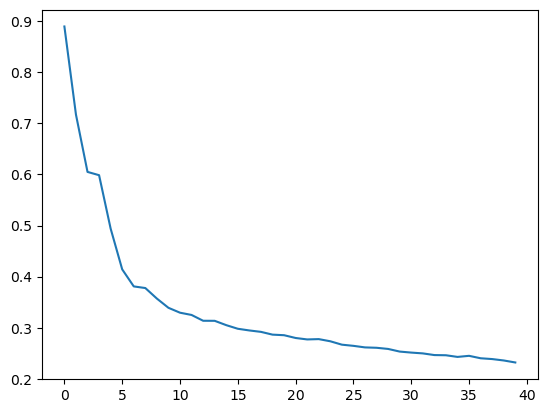

In [80]:
plt.plot(history1.history['loss'])

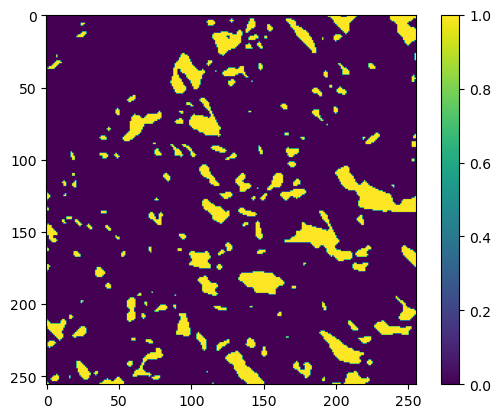

In [88]:
plt.imshow(val_y[15,:,:,0])
plt.colorbar()

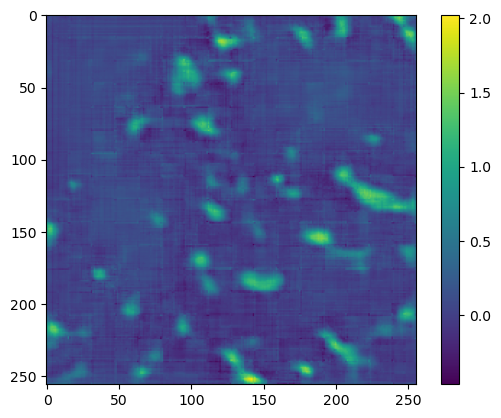

In [89]:
valPred = model.predict(val_x)
plt.imshow(valPred[15,:,:,0])
plt.colorbar()

#### 2. Mean squared error

In [ ]:
## Try soft dice loss
model.compile("adam","mse")
history1=model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=200, batch_size=10, shuffle=True)

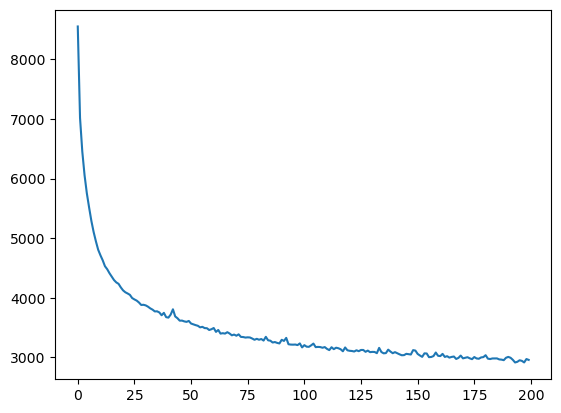

In [13]:
plt.plot(history1.history['loss'])

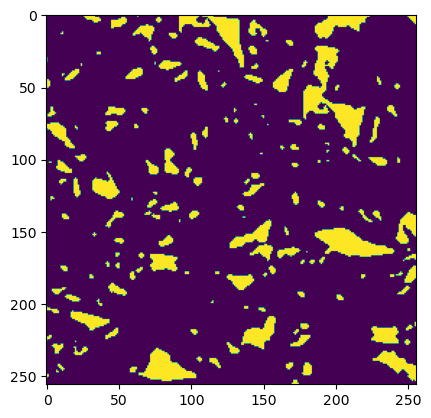

In [15]:
plt.imshow(train_y[15,:,:,0])

In [16]:
trainPred = model.predict(train_x)

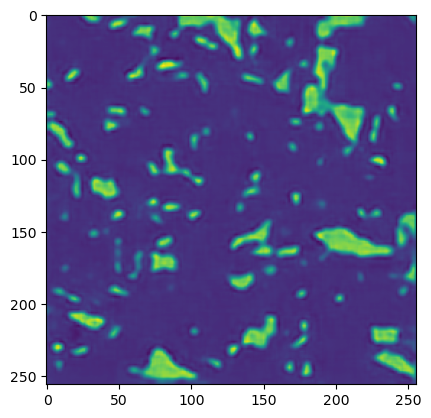

In [17]:
plt.imshow(trainPred[15,:,:,0])

In [18]:
valPred = model.predict(val_x)

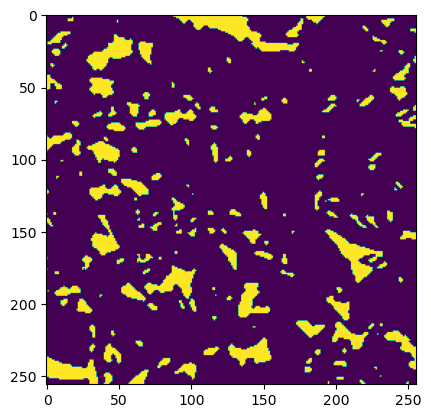

In [19]:
plt.imshow(val_y[15,:,:,0])

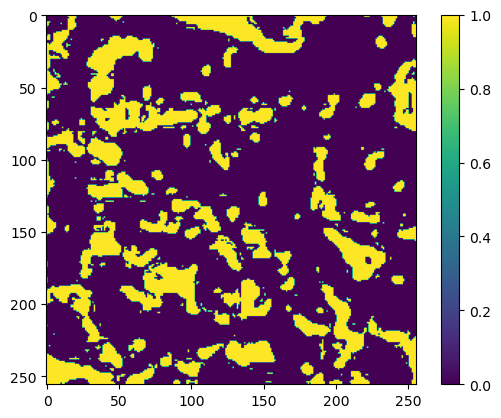

In [22]:
## plot >10
plt.imshow(valPred[15,:,:,0]>10)
plt.colorbar()

#### 3. sparse categorical crossentropy

In [138]:
# scc = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.compat.v1.losses.Reduction.NONE)
model.compile("adam", loss=pixelwise_crossentropy)
history1=model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=100, batch_size=10, shuffle=True)

Train on 160 samples, validate on 40 samples
Epoch 1/100
160/160 [==============================] - 33s 208ms/sample - loss: 279224.0615 - val_loss: 438002.7031
Epoch 2/100
160/160 [==============================] - 26s 166ms/sample - loss: 222817.1562 - val_loss: 339424.4844
Epoch 3/100
160/160 [==============================] - 24s 153ms/sample - loss: 206437.1514 - val_loss: 364418.7031
Epoch 4/100
160/160 [==============================] - 25s 155ms/sample - loss: 198038.2412 - val_loss: 311925.6094
Epoch 5/100
160/160 [==============================] - 25s 158ms/sample - loss: 190600.7842 - val_loss: 249008.6250
Epoch 6/100
160/160 [==============================] - 24s 153ms/sample - loss: 186384.2588 - val_loss: 256154.6680
Epoch 7/100
160/160 [==============================] - 26s 160ms/sample - loss: 180510.5742 - val_loss: 246301.4570
Epoch 8/100
160/160 [==============================] - 24s 150ms/sample - loss: 177092.9814 - val_loss: 242962.9219
Epoch 9/100
160/160 [======

160/160 [==============================] - 24s 150ms/sample - loss: 119991.3467 - val_loss: 121642.4316
Epoch 71/100
160/160 [==============================] - 24s 149ms/sample - loss: 119476.4434 - val_loss: 121172.6309
Epoch 72/100
160/160 [==============================] - 24s 150ms/sample - loss: 119461.0552 - val_loss: 126054.0371
Epoch 73/100
160/160 [==============================] - 24s 149ms/sample - loss: 120049.8442 - val_loss: 120591.4141
Epoch 74/100
160/160 [==============================] - 24s 149ms/sample - loss: 118775.7383 - val_loss: 120355.2793
Epoch 75/100
160/160 [==============================] - 24s 149ms/sample - loss: 118239.8550 - val_loss: 121909.8633
Epoch 76/100
160/160 [==============================] - 24s 149ms/sample - loss: 118631.5933 - val_loss: 119723.8125
Epoch 77/100
160/160 [==============================] - 24s 150ms/sample - loss: 118013.0815 - val_loss: 119634.7832
Epoch 78/100
160/160 [==============================] - 24s 150ms/sample - lo

Text(0.5, 0, 'iteration')

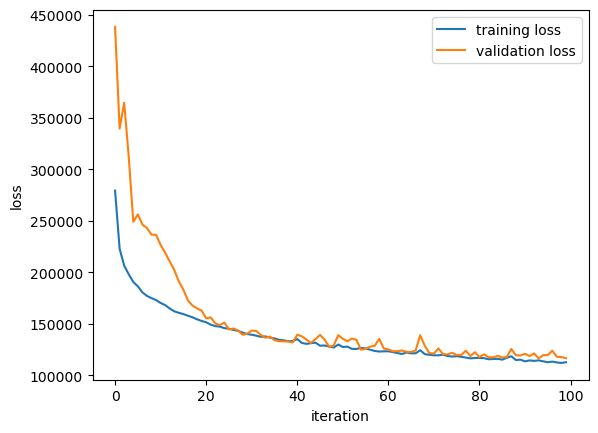

In [139]:
plt.figure()
plt.plot(history1.history['loss'],label="training loss")
plt.plot(history1.history['val_loss'],label="validation loss")
plt.legend()
plt.ylabel("loss")
plt.xlabel("iteration")

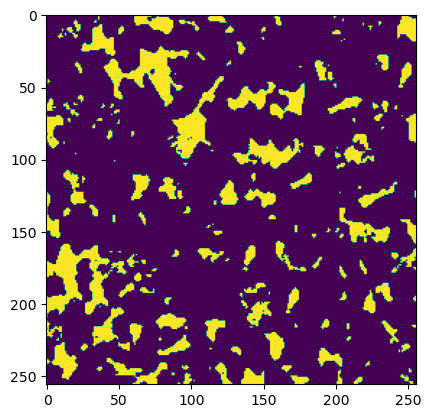

In [140]:
plt.imshow(train_y[15,:,:,0])

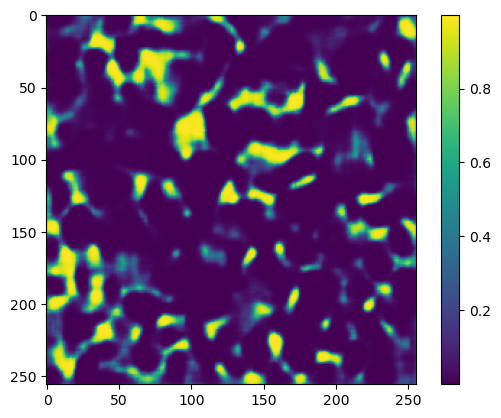

In [141]:
trainPred = model.predict(train_x)
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z
plt.imshow(sigmoid(trainPred[15,:,:,0]))
plt.colorbar()

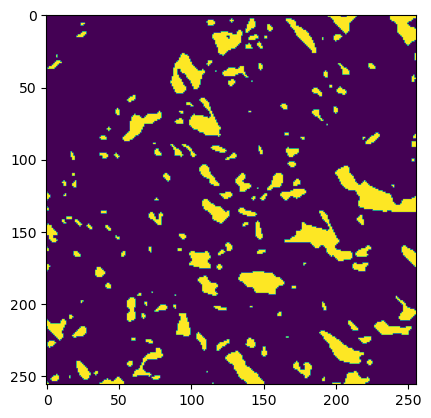

In [142]:
plt.imshow(val_y[15,:,:,0])

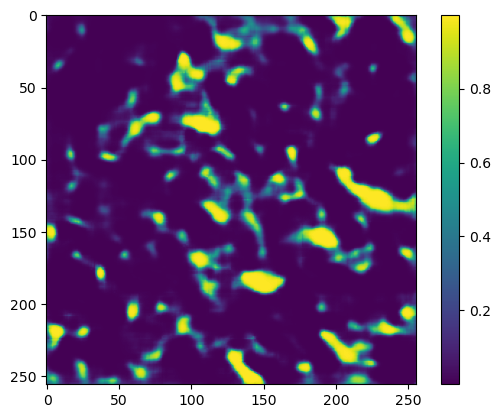

In [154]:
valPred = model.predict(val_x)
plt.imshow(sigmoid(valPred[15,:,:,0]))
plt.colorbar()

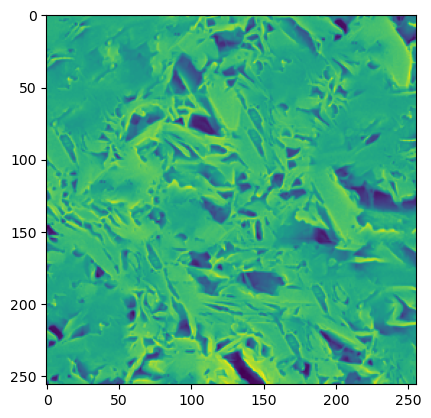

In [144]:
## plot input
plt.imshow(val_x[15,:,:,0])

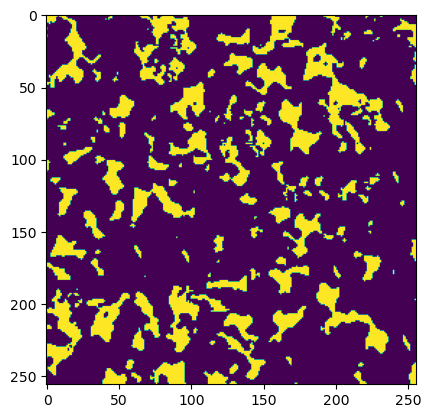

In [155]:
plt.imshow(val_y[38,:,:,0])

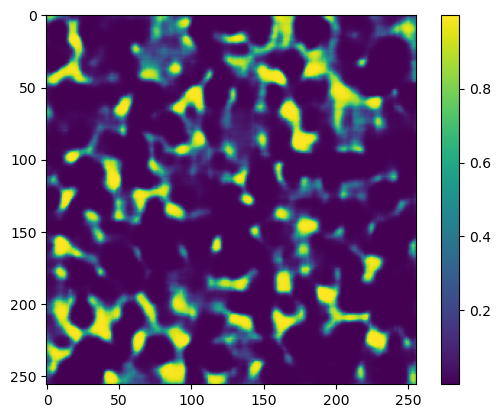

In [153]:
valPred = model.predict(val_x)
plt.imshow(sigmoid(valPred[38,:,:,0]))
plt.colorbar()

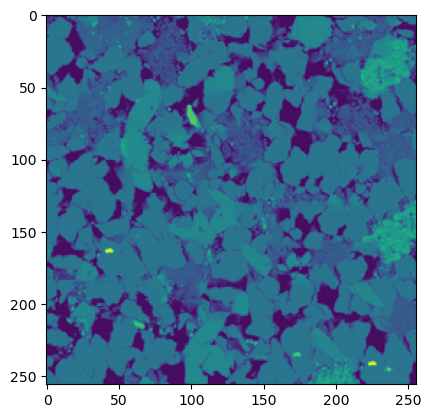

In [149]:
## plot input
plt.imshow(val_x[38,:,:,0])